In [0]:
import pandas as pd

In [0]:
# mount google drive
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
# load news data
data = pd.read_csv('/content/drive/My Drive/Capstone Data/news_guardian_cuttedentity.csv')

In [0]:
data.head()

,timestamp,sectionName,url,content,sentiment,entity
0,2017-10-01T18:55:00Z,Opinion,https://www.theguardian.com/commentisfree/2017...,Ikea celebrates its 30th birthday in the UK th...,9.999999e-01,eBay
1,2017-10-01T18:05:36Z,Business,https://www.theguardian.com/business/2017/oct/...,Alan Quinn criticises Tory governments for the...,3.673728e-07,Boeing|Boeing|Boeing|Boeing|Boeing|Boeing|Airb...
2,2017-10-01T17:40:37Z,Business,https://www.theguardian.com/business/2017/oct/...,The country’s largest supplier of supermarket ...,2.035094e-02,Tesco|Tesco|Tesco
3,2017-10-01T13:36:30Z,Business,https://www.theguardian.com/business/2017/oct/...,Tesco’s recovery under Dave Lewis since a seri...,9.995096e-01,Tesco|Tesco|Dell|the Bank of England
4,2017-10-01T13:00:03Z,Global,https://www.theguardian.com/us-news/2017/oct/0...,"On an evening last September, I received a cal...",1.971618e-03,Facebook


In [0]:
# Load company and stock ticker
company_table = pd.read_csv('/content/drive/My Drive/Capstone Data/company_table_cleaned.csv')

In [0]:
# Covert stock ticker to dictionary
stock_dic = {}
for i in range(len(company_table)):
  stock_dic[company_table.loc[i, 'company_name']] = company_table.loc[i, 'stock_ID']

In [0]:
# Sort the news data according to timestamp
data['timestamp'] = pd.to_datetime(data['timestamp'])
# timestamp from 2017-10-01 to 2019-10-05
data['yearmonth'] = data['timestamp'].map(lambda x: 100*x.year + x.month)
data['yearmonth'] = pd.to_datetime(data['yearmonth'], format='%Y%m')
data.sort_values('yearmonth')

,timestamp,sectionName,url,content,sentiment,entity,yearmonth
0,2017-10-01 18:55:00+00:00,Opinion,https://www.theguardian.com/commentisfree/2017...,Ikea celebrates its 30th birthday in the UK th...,9.999999e-01,eBay,2017-10-01
922,2017-10-20 09:37:18+00:00,Film,https://www.theguardian.com/film/2017/oct/20/s...,Hollywood actor believes The Day I Met El Chap...,9.999950e-01,Netflix,2017-10-01
921,2017-10-20 09:47:01+00:00,Teacher Network,https://www.theguardian.com/teacher-network/20...,What’s it like to work as an educator on a hos...,9.947329e-01,Facebook,2017-10-01
920,2017-10-20 10:01:27+00:00,Television & radio,https://www.theguardian.com/tv-and-radio/2017/...,It’s time to rejoin Eleven and the gang in 80s...,9.999993e-01,Amazon,2017-10-01
919,2017-10-20 10:30:05+00:00,Cities,https://www.theguardian.com/cities/2017/oct/20...,Berdymukhamedov’s presentation of a puppy to V...,9.999999e-01,Facebook,2017-10-01
...,...,...,...,...,...,...,...
29196,2019-10-02 12:57:17+00:00,Business,https://www.theguardian.com/business/2019/oct/...,Deliveroo made a loss of £232m last year despi...,9.999892e-01,Amazon|Amazon,2019-10-01
29197,2019-10-02 11:39:14+00:00,World news,https://www.theguardian.com/world/2019/oct/02/...,The high court in Delhi has ordered Google and...,9.981778e-01,Google|Facebook|Facebook|Facebook,2019-10-01
29198,2019-10-02 10:00:20+00:00,Music,https://www.theguardian.com/music/2019/oct/02/...,"For Parents and Carers in Performing Arts, the...",1.450401e-07,Google,2019-10-01
29200,2019-10-02 07:00:12+00:00,Games,https://www.theguardian.com/games/2019/oct/02/...,Four large companies – including Sony and Sega...,8.094236e-01,Sony|Sony|Sony,2019-10-01


In [0]:
# The time range is from 2017-10 to 2019-10
# Create a dictionary to store the frequency of companies in news data
time_range = pd.date_range(start='2017-10-01', end='2019-10-02', freq='MS')
number_entity = {}
for t in time_range:
  number_entity[t] = {}

In [0]:
# Calculate the frequency of companies
for i in range(len(data)):
  entity_list = list(set(data.loc[i, 'entity'].split('|')))
  for j in range(len(entity_list) - 1):
    for k in range(j + 1, len(entity_list)):
      if (entity_list[j], entity_list[k]) in number_entity[data.loc[i, 'yearmonth']]:
        number_entity[data.loc[i, 'yearmonth']][(entity_list[j], entity_list[k])] += 1
      else:
        if (entity_list[k], entity_list[j]) in number_entity[data.loc[i, 'yearmonth']]:
          number_entity[data.loc[i, 'yearmonth']][(entity_list[k], entity_list[j])] += 1
        else:
          number_entity[data.loc[i, 'yearmonth']][(entity_list[j], entity_list[k])] = 1

In [0]:
# Create a new data frame to store linkage data
linkage_data = pd.DataFrame(columns=['yearmonth', 'main_entity', 'relate_entity', 'number_news'])
index = 0
for t in number_entity.keys():
  for (entity_1, entity_2) in number_entity[t].keys():
    linkage_data.loc[index] = [t, entity_1, entity_2, number_entity[t][(entity_1, entity_2)]]
    index += 1 
    linkage_data.loc[index] = [t, entity_2, entity_1, number_entity[t][(entity_1, entity_2)]]
    index += 1
linkage_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8108 entries, 0 to 8107
Data columns (total 4 columns):
yearmonth        8108 non-null datetime64[ns]
main_entity      8108 non-null object
relate_entity    8108 non-null object
number_news      8108 non-null object
dtypes: datetime64[ns](1), object(3)
memory usage: 316.7+ KB


In [0]:
# Calculate f in the equation
import numpy as np
linkage_data['number_news'] = pd.to_numeric(linkage_data['number_news'])
linkage_data['f'] = np.log(linkage_data['number_news'] + 1)
linkage_data.head()

,yearmonth,main_entity,relate_entity,number_news,f
0,2017-10-01,Airbus,Boeing,13,2.639057
1,2017-10-01,Boeing,Airbus,13,2.639057
2,2017-10-01,the Bank of England,Dell,4,1.609438
3,2017-10-01,Dell,the Bank of England,4,1.609438
4,2017-10-01,the Bank of England,Tesco,5,1.791759


In [0]:
# Calculate weigth
new_df = linkage_data.groupby(['yearmonth', 'main_entity'])['f'].sum()
linkage_data['weight'] = 0
for i in range(len(linkage_data)):
  sum_f = new_df[(linkage_data.loc[i, 'yearmonth'], linkage_data.loc[i, 'main_entity'])]
  linkage_data.loc[i, 'weight'] = linkage_data.loc[i, 'f'] / sum_f

In [0]:
linkage_data.head()

,yearmonth,main_entity,relate_entity,number_news,f,weight
0,2017-10-01,Airbus,Boeing,13,2.639057,0.247354
1,2017-10-01,Boeing,Airbus,13,2.639057,0.123109
2,2017-10-01,the Bank of England,Dell,4,1.609438,0.068476
3,2017-10-01,Dell,the Bank of England,4,1.609438,0.078305
4,2017-10-01,the Bank of England,Tesco,5,1.791759,0.076233


In [0]:
!pip install yfinance

  Created wheel for yfinance: filename=yfinance-0.1.50-py2.py3-none-any.whl size=21556 sha256=f10cf2ac3ba8d6debd70c8602e07aca227829853790c921eed233e65fd67a208
  Stored in directory: /root/.cache/pip/wheels/19/2a/e6/b4d4cc977576e18220a36866acf2f2cf7241f16af5f8795b17
Successfully built yfinance


In [0]:
tickers = []
for i in range(len(company_table)):
  tickers.append(company_table.loc[i, 'stock_ID'])

In [0]:
# Get stock data
import yfinance as yf
from pandas_datareader import data as pdr
yf.pdr_override()
stock_data = pdr.get_data_yahoo(tickers, start="2017-09-01", end="2019-10-05", interval='1mo')

[*********************100%***********************]  65 of 65 completed

2 Failed downloads:
- RDS.A: No data found, symbol may be delisted
- LNKD: No data found for this date range, symbol may be delisted


In [0]:
# Drop missing values
new_stock = stock_data['Adj Close'].drop(columns=['LNKD', 'RDS.A', 'HPE'])
new_stock.dropna(inplace=True)
new_stock.head()

,AAPL,ACN,ADBE,AMZN,AVGO,AXP,BA,BAC,BMWYY,BNPQY,BP,C,CAKE,CAT,COF,COP,CRM,CSCO,CVX,DELL,EADSY,EBAY,F,FB,FJTSY,GE,GM,GOOGL,GS,HAL,HMC,HON,HPQ,HSBC,HTHIY,IBM,INTC,JPM,LNVGY,MS,MSFT,MUFG,NFLX,NSANY,ORCL,PNC,PSX,PTR,SAP,SHI,SIEGY,SNE,STFGX,TCEHY,TM,TSCDY,TSLA,TXN,UBS,UTX,VWAGY,WFC
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2017-09-01,149.056900,129.766235,149.179993,961.349976,226.113617,87.535217,242.398621,24.358061,30.709398,35.697437,33.672630,68.899864,39.558796,117.916298,81.351181,47.837139,93.419998,31.469330,107.709755,42.751938,22.978956,38.036285,10.343539,170.869995,13.744394,22.007660,36.534786,973.719971,229.811493,43.513386,27.453051,129.682068,18.742529,43.482399,67.560539,131.138336,36.027630,90.017685,9.686975,45.571968,72.039268,6.053484,181.350006,17.343719,46.603172,126.737061,85.211098,58.549339,106.545158,51.222374,66.180054,36.878853,71.203697,43.705647,113.778214,7.234638,341.100006,84.449081,14.991097,110.362587,15.630381,51.158707
2017-10-01,163.486755,136.769974,175.160004,1105.280029,247.042038,92.431618,245.993469,26.328623,31.036095,34.540779,35.635334,69.619743,42.019482,128.402161,88.577271,48.888508,102.339996,31.955921,106.233902,45.830566,24.899527,37.225315,10.602777,180.059998,14.700252,18.532152,39.688576,1033.040039,234.936935,40.590744,29.287689,131.896225,20.375496,42.919182,76.836105,139.255371,43.038254,94.824409,10.171764,47.303268,80.443352,6.461783,196.429993,17.701090,49.061047,128.636658,84.718109,60.794724,110.966324,51.804642,67.368019,43.004833,72.399078,44.830135,120.167580,6.939541,331.529999,91.090820,14.868722,113.861320,17.334211,52.077061
2017-11-01,166.204468,143.575348,181.470001,1176.750000,260.175262,94.915840,263.938995,27.078398,30.464375,33.534222,35.109612,71.514168,46.058014,134.256744,88.404305,48.890553,107.029999,33.864895,109.075600,43.322258,25.142023,34.288036,10.953147,177.179993,35.038967,16.813148,39.790150,1036.170044,239.936417,39.679020,31.407257,142.692383,20.280951,44.134956,74.015717,134.790100,42.423283,99.085396,9.969035,46.204559,81.400795,6.385651,187.580002,17.719299,47.474041,125.295547,90.745483,62.688179,110.713692,50.751427,63.626389,46.363194,74.511848,50.930218,122.435249,7.484095,308.850006,92.242638,15.017322,112.083435,19.197557,52.383179
2017-12-01,164.258896,148.503143,175.240005,1169.469971,240.480057,96.470085,282.719269,28.497004,31.462610,32.977966,37.368549,70.784782,45.548542,149.884384,96.124443,52.743755,102.230003,36.148979,115.833298,45.005539,24.036242,37.324219,10.926900,176.460007,13.546994,16.040977,37.850967,1053.400024,247.610641,46.412487,32.104359,141.062668,19.864927,45.903912,75.377617,140.062988,43.930950,101.379578,10.183026,49.883816,83.141182,6.918581,191.960007,18.119942,45.751575,136.454788,94.801605,64.915779,109.178429,48.807682,64.795654,44.530460,74.270912,51.666603,123.239609,8.125315,311.350006,99.021706,16.075001,122.013107,18.695887,56.672424
2018-01-01,162.511780,155.885147,199.759995,1450.890015,233.716171,96.557503,339.721344,30.891064,34.647896,36.633358,38.044258,74.656479,46.503384,154.830414,100.352440,56.510479,113.910004,39.207020,115.981323,39.700996,27.848282,40.132927,9.597125,186.889999,13.084172,15.072876,39.518501,1182.219971,260.372162,51.210884,33.471703,146.866699,22.194178,47.921764,79.405357,149.447983,45.815338,109.655632,10.409516,53.762718,92.345612,7.251664,270.299988,19.576822,49.922249,149.439240,95.973167,73.343498,110.043221,52.900673,71.324791,47.492550,78.469658,58.881222,133.657364,8.517703,354.309998,103.980370,17.762045,131.998352,20.547674,61.445732
2018-02-01,172.887787,156.185867,209.130005,1512.449951,232.236771,95.055763,347.237305,30.987595,31.880056,34.955765,34.550137,71.812149,43.950851,147.761108,94.531685,52.186432,116.250000,42.580299,103.555092,41.135105,28.905565,42.387810,9.510763,178.320007,11.452919,13.152647,36.667130,1103.920044,255.551361,44.268322,34.230484,138.993088,22.260799,44.117176,74.624229,142.263168,46.909809,110.06

In [0]:
tickers = set(tickers)
tickers.remove('LNKD')
tickers.remove('RDS.A')
tickers.remove('HPE')

In [0]:
# Calculate stock return
returns = {}
for ticker in tickers:
  ret = new_stock[ticker].pct_change()
  ret *= 100
  for i in range(len(time_range)):
    returns[(time_range[i], ticker)] = ret[i]

In [0]:
# Use the previous month's return to calculate linkage
linkage_data['new_date'] = linkage_data['yearmonth'].map(lambda x: 100*(x.year + int(x.month / 12)) + int(x.month % 12 + 1))
linkage_data['new_date'] = pd.to_datetime(linkage_data['new_date'], format='%Y%m')
linkage_data.head()

,yearmonth,main_entity,relate_entity,number_news,f,weight,new_date,weight_return
0,2017-10-01,Airbus,Boeing,13,2.639057,0.247354,2017-11-01,0.0
1,2017-10-01,Boeing,Airbus,13,2.639057,0.123109,2017-11-01,0.0
2,2017-10-01,the Bank of England,Dell,4,1.609438,0.068476,2017-11-01,0.0
3,2017-10-01,Dell,the Bank of England,4,1.609438,0.078305,2017-11-01,0.0
4,2017-10-01,the Bank of England,Tesco,5,1.791759,0.076233,2017-11-01,0.0


In [0]:
linkage_data.head()

,yearmonth,main_entity,relate_entity,number_news,f,weight,new_date
0,2017-10-01,Airbus,Boeing,13,2.639057,0.247354,2017-11-01
1,2017-10-01,Boeing,Airbus,13,2.639057,0.123109,2017-11-01
2,2017-10-01,the Bank of England,Dell,4,1.609438,0.068476,2017-11-01
3,2017-10-01,Dell,the Bank of England,4,1.609438,0.078305,2017-11-01
4,2017-10-01,the Bank of England,Tesco,5,1.791759,0.076233,2017-11-01


In [0]:
# Calculate weighted return
for i in range(len(linkage_data)):
  if linkage_data.loc[i, 'relate_entity'] not in stock_dic.keys() or (linkage_data.loc[i, 'new_date'], stock_dic[linkage_data.loc[i, 'relate_entity']]) not in returns.keys():
    linkage_data.loc[i, 'weight_return'] = 0
    continue
  linkage_data.loc[i, 'weight_return'] = returns[(linkage_data.loc[i, 'new_date'], stock_dic[linkage_data.loc[i, 'relate_entity']])] * linkage_data.loc[i, 'weight']
linkage_data.head()

,yearmonth,main_entity,relate_entity,number_news,f,weight,new_date,weight_return
0,2017-10-01,Airbus,Boeing,13,2.639057,0.247354,2017-11-01,0.366834
1,2017-10-01,Boeing,Airbus,13,2.639057,0.123109,2017-11-01,1.028937
2,2017-10-01,the Bank of England,Dell,4,1.609438,0.068476,2017-11-01,0.493107
3,2017-10-01,Dell,the Bank of England,4,1.609438,0.078305,2017-11-01,0.000000
4,2017-10-01,the Bank of England,Tesco,5,1.791759,0.076233,2017-11-01,-0.310952


In [0]:
linkage_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8108 entries, 0 to 8107
Data columns (total 8 columns):
yearmonth        8108 non-null datetime64[ns]
main_entity      8108 non-null object
relate_entity    8108 non-null object
number_news      8108 non-null int64
f                8108 non-null float64
weight           8108 non-null float64
new_date         8108 non-null datetime64[ns]
weight_return    8108 non-null float64
dtypes: datetime64[ns](2), float64(3), int64(1), object(2)
memory usage: 890.1+ KB


In [0]:
# Calculate linkage
linkage = linkage_data.groupby(['new_date', 'main_entity'])['weight_return'].sum()
news_sum = linkage_data.groupby(['new_date', 'main_entity'])['number_news'].sum()
new_linkage = pd.DataFrame(columns = ['timestamp', 'entity', 'weight_return', 'sum'])

In [0]:
i = 0
for (date, entity) in linkage.index:
  new_linkage.loc[i] = [date, entity, linkage[(date, entity)], news_sum[date, entity]]
  i += 1

In [0]:
new_linkage['sum'] = pd.to_numeric(new_linkage['sum'])
new_linkage['linkage'] = new_linkage['weight_return'] * np.log(new_linkage['sum'] + 1)
new_linkage=new_linkage[~new_linkage['timestamp'].isin([linkage_data.loc[8107, 'new_date']])]

In [0]:
new_linkage.to_csv('/content/drive/My Drive/Capstone Data/news_guardian_linkage.csv', index=False)

In [0]:
# Create network to show the connections of companies
for (key1, key2) in number_entity[time_range[0]]:
  G.add_node(key1)
  G.add_node(key2)
  G.add_edge(key1, key2)

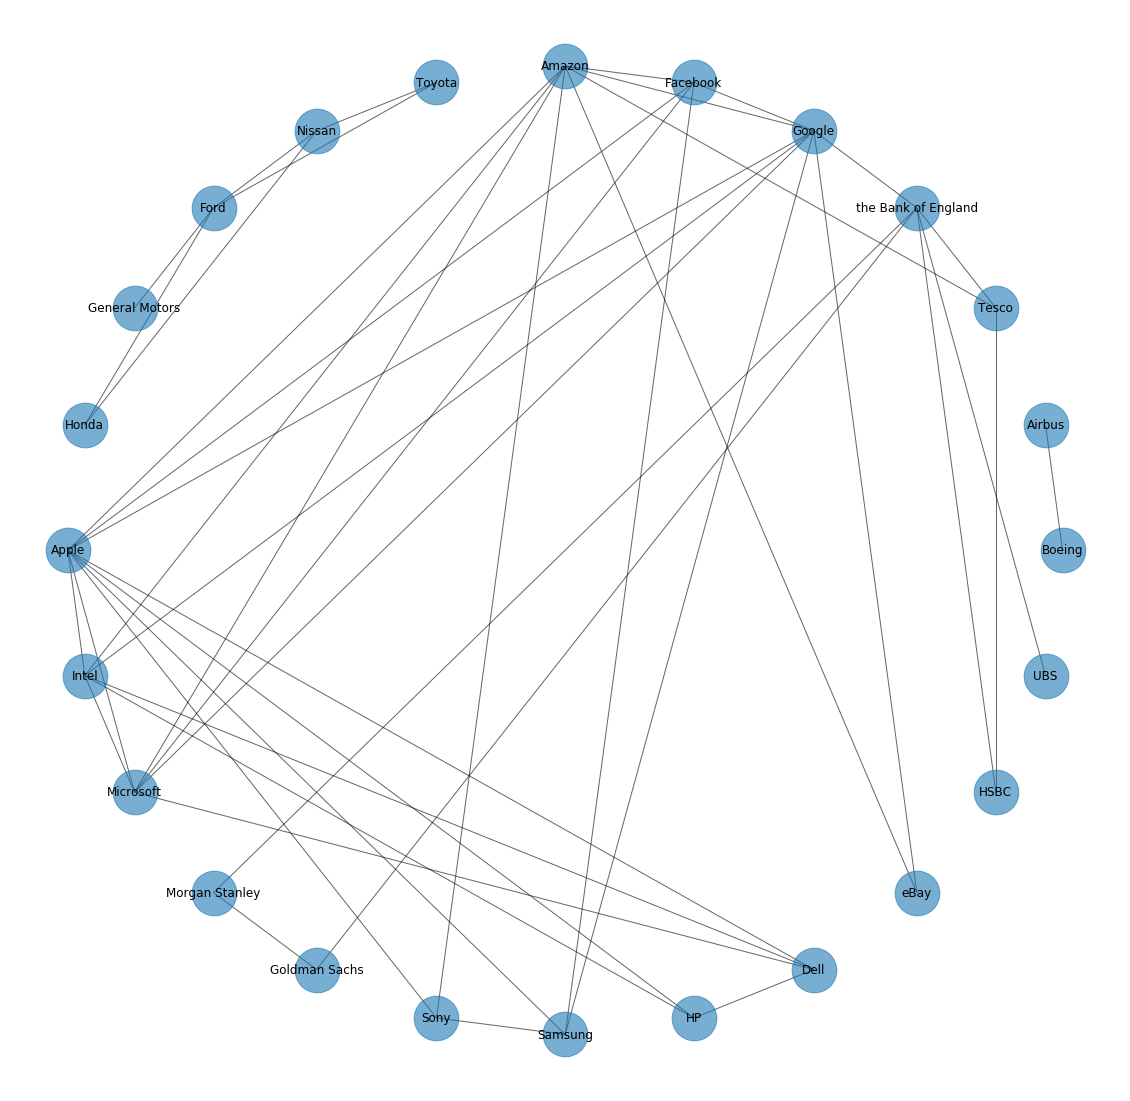

In [0]:
import matplotlib.pyplot as plt

plt.figure(3,figsize=(20,20))
pos = nx.circular_layout(G)
labels = nx.draw_networkx_labels(G, pos=pos)
nx.draw(G, label=labels, pos=pos, node_size=2000, alpha=0.6, font_size=24)

In [0]:
import networkx as nx
new_linkage = pd.read_csv('/content/drive/My Drive/Capstone Data/news_guardian_linkage.csv', parse_dates=['timestamp'])
G = nx.Graph()
for (key1, key2) in number_entity[time_range[0]]:
  if number_entity[time_range[0]][(key1, key2)] >= 5:
    G.add_node(key1)
    G.add_node(key2)
    G.add_edge(key1, key2)

In [0]:
# Store the stock return
new_linkage = pd.read_csv('/content/drive/My Drive/Capstone Data/news_guardian_linkage.csv', parse_dates=['timestamp'])
for i in range(len(new_linkage)):
  if new_linkage.loc[i, 'entity'] in stock_dic.keys() and (new_linkage.loc[i, 'timestamp'], stock_dic[new_linkage.loc[i, 'entity']]) in returns.keys():
    new_linkage.loc[i, 'return'] = returns[(new_linkage.loc[i, 'timestamp'], stock_dic[new_linkage.loc[i, 'entity']])]
  else:
    new_linkage.loc[i, 'return'] = 0

1113

In [0]:
# Panel OLS Regression
etdata = new_linkage.set_index(['entity', 'timestamp'])
etdata.head()
PanelOLS(etdata['return'],etdata['linkage'],entity_effects=True,time_effects=True).fit(debiased=True)

Dep. Variable:,return,R-squared:,0.0329
Estimator:,PanelOLS,R-squared (Between):,0.1926
No. Observations:,1113,R-squared (Within):,0.2417
Date:,"Wed, Nov 20 2019",R-squared (Overall):,0.2431
Time:,22:30:57,Log-likelihood,-3502.7
Cov. Estimator:,Unadjusted,,
,,F-statistic:,34.490
Entities:,75,P-value,0.0000
Avg Obs:,14.840,Distribution:,"F(1,1014)"
Min Obs:,1.0000,,
Max Obs:,24.000,F-statistic (robust):,34.490


In [0]:
new_entities = []

In [0]:
# when loading saved data
entities = pd.read_csv('/content/entities-5.csv', header=None)
entities.fillna("", inplace=True)
new_entities = entities[1].values.tolist()

In [0]:
# the first one column will be set to 0 because of loading it to dataframe
new_entities = new_entities[1:]

In [0]:
len(new_entities)

225231

In [0]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 269823 entries, 0 to 269822
Data columns (total 6 columns):
Unnamed: 0     269823 non-null int64
timestamp      269823 non-null object
sectionName    269823 non-null object
url            269823 non-null object
content        269793 non-null object
sentiment      269823 non-null float64
dtypes: float64(1), int64(1), object(4)
memory usage: 12.4+ MB
